In [314]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np

# Uncomment the next two lines if running for the book
import warnings
warnings.filterwarnings("ignore")

import jax
import jax.numpy as jnp
import jax.random as jrandom
import gpjax as gpx
import optax

jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0)

# Example – Surrogate for stochastic heat equation

## Deterministic, physical model

Consider the steady state heat equation on a heterogeneous rod with no heat sources:

$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}u(x)\right) = 0,
$$

and boundary values:

$$
u(0) = 1\;\text{ and }\;u(1) = 0.
$$

The thermal conductivity $c$ lives in some function space $\mathcal{C},$ and the temperature $u$ lives in a function space $\mathcal{U}$.
Let $F: \mathcal{C} \rightarrow \mathcal{U}$ be the solver for the boundary value problem, i.e., $u = F(c)$.
Suppose we are uncertain about the thermal conductivity, $c(x)$, and we want to propagate this uncertainty to the temperature field, $u(x)$.

## Uncertain thermal conductivity

Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $c(x)$ that represents our uncertainty.
This requires assigning a probability measure on the function space $\mathcal{C}$.
Let's say the conductivity $c$ is given by

$$
c(x; \xi) = c_0(x) \exp\Big\{ g(x; \xi) \Big\},
$$

where $c_0$ is the "mean" thermal conductivity and $g$ follows a zero-mean Gaussian process, i.e.,

$$
\begin{align*}
g \sim \operatorname{GP}(0, k).
\end{align*}
$$

(The reason for the exponential is that $c(x; \xi)$ must be positive.) 
Finally, let $k$ be the squared-exponential kernel.

Let's implement the Karhunen-Loeve expansion of the random field $c$:

<!-- In particular, we want to build a surrogate for the stochastic heat equation solver. -->

<!-- For now, we will just give you a model.
We will model $c = c(x;\boldsymbol{\xi})$ as:
$$
c(x;\boldsymbol{\xi}) = c_0(x)\exp\{g(x;\boldsymbol{\xi})\},
$$
where $c_0(x)$ is a "mean" conductivity level and $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $c(x;\boldsymbol{\xi})$ must be positive.
We will assume that the random field ia a [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
This is a field that it is no-where continuous and it is actually a fractal (when you zoom in the spatial dimension, the field resembles itself at a larger scale).
The Karhunen-Loeve expansion of the field is:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^\infty\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are the eigenfunctions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.
For the record, this corresponds to a random field known as the 
Since, we cannot actually work with the infinite sums, let's truncate at $i=d$ and define:
$$
g_d(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x).
$$ -->


In [251]:
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, y=None, *, input_dim):

        self.k = k
        if input_dim is None:
            self.input_dim = 1
        else:
            self.input_dim = input_dim

        # Generate quadrature points
        if Xq is None:
            if input_dim is None:
                self.input_dim = 1
            if self.input_dim == 1:
                Xq = jnp.linspace(0, 1, nq)[:, None]
                wq = jnp.ones((nq, )) / nq
            elif self.input_dim == 2:
                nq = int(jnp.sqrt(nq))
                x = jnp.linspace(0, 1, nq)
                X1, X2 = jnp.meshgrid(x, x)
                Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = jnp.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        else:
            self.input_dim = Xq.shape[1]
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha

        # Evaluate the covariance function at the quadrature points
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            self.D = gpx.Dataset(X, y[:, None])
            prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=k)
            likelihood = gpx.likelihoods.Gaussian(num_datapoints=X.shape[0])
            posterior = prior * likelihood
            posterior.likelihood.obs_stddev = gpx.parameters.Static(1e-6)
            self.posterior = posterior
            Kq = posterior.predict(Xq, train_data=self.D).covariance()
        else:
            self.D = None
            self.prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=k)
            Kq = self.prior.predict(Xq).covariance()
        
        # Get the eigenvalues/eigenvectors of the discretized covariance function
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)

        # Keep only the eigenvalues that explain alpha% of the energy
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.lam = lam
        self.sqrt_lam = jnp.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.D is not None:
            nq = self.Xq.shape[0]
            Xf = jnp.vstack([self.Xq, x])
            latent_dist = self.posterior.predict(Xf, train_data=self.D)
            m = latent_dist.mean()
            C = latent_dist.covariance()
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:]
        else:
            Kc = self.prior.kernel.cross_covariance(x, self.Xq)
            self.tmp_mu = 0.
        phi = jnp.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + jnp.dot(phi, xi * self.sqrt_lam)

In [307]:
k = gpx.kernels.RBF(lengthscale=0.1, variance=0.5)
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=0.95, input_dim=1)

def c(x, xi):
    """Compute the random thermal conductivity field for a given xi."""
    return jnp.exp(kle(x, xi))

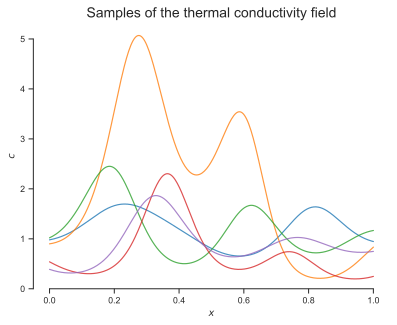

In [308]:
x = jnp.linspace(0, 1, 300)[:, None]
fig, ax = plt.subplots()
ax.set_title("Samples of the thermal conductivity field", fontsize=14)
for i in range(5):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, shape=(kle.num_xi,))
    f = c(x, xi)
    ax.plot(x, f, alpha=0.8)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
sns.despine(trim=True);

## Reduce dimensionality of the stochastic model input

Suppose we are interested the temperature at the *center* of the rod, i.e., at $x = 0.5$.
Our model is therefore 

$$
u_{0.5} \equiv u_{0.5}(c) \equiv \underbrace{F(c)}_{= u}(0.5).
$$

The quantity of interest $u_{0.5}$ is stochastic because $c$ is stochastic.
To quantify uncertainty in $u_{0.5}$, replace $c$ with its truncated Karhunen-Loeve expansion $\hat{c}$:

$$
u_{0.5} \approx \hat{u}_{0.5}(\xi) \equiv F\Big(\hat{c}(\xi)\Big)(0.5).
$$

The infinite-dimensional uncertainty propagation problem has now been reduced to a finite one!
This is extremely useful.
For example, to sample $u_{0.5}$, we can simply follow these steps:
1. Sample $\xi$ (which are i.i.d. Gaussian).
2. Evaluate $\hat{c}(\xi)$, the truncated Karhunen-Loeve expansion at $\xi$. The result is a sample of the conductivity field $c.$
3. Numerically solve the deterministic heat equation with $c$. The result is a sample of $u_{0.5}$.

Let's visualize a few samples of the entire temperature field $u(x)$. 

First, we need a solver for $F$. We will use the [finite volume method](https://en.wikipedia.org/wiki/Finite_volume_method) as implemented in [FiPy](http://www.ctcms.nist.gov/fipy). Here is the solver:

In [310]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, c=c, nx=100, value_left=1., value_right=0.):
        self.c = c
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        c_val = self.c(x[:, None], xi)
        self.C.setValue(c_val)
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()

In [311]:
solver = SteadyStateHeat1DSolver(nx=500)

Now let's (approximately) sample $u$:

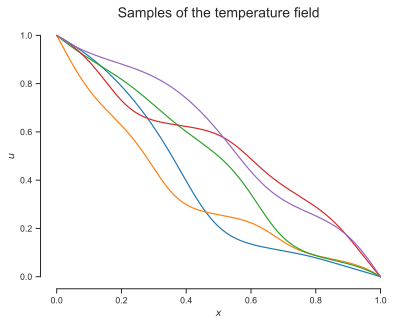

In [312]:
fig, ax = plt.subplots()
ax.set_title("Samples of the temperature field", fontsize=14)
for i in range(5):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    ax.plot(x, y)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")
sns.despine(trim=True);

## Surrogate for the stochastic model

Uncertainty propagation can still be slow, depending on how fast the solver $F$ is.
To speed it up, we will build a Gaussian process surrogate for $\hat{u}_{0.5}(\xi)$. This GP will take the coefficients $\xi$ as inputs and will output the quantity of interest $\hat{u}_{0.5}$.

First, we need some training data:

In [364]:
xis = []
u05s = []
for i in range(200):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    xis.append(xi)
    u05s.append(y[x==0.5][0])
xis = jnp.stack(xis, axis=0)
u05s = jnp.array(u05s)

from sklearn.model_selection import train_test_split
key, key_split = jrandom.split(key)
xi_train, xi_test, u05_train, u05_test = train_test_split(xis, u05s, test_size=0.2, random_state=int(jrandom.randint(key_split, shape=(), minval=0, maxval=1e6)))

Now let's train the surrogate:

In [365]:
def train_gp(X, y, posterior=None, measurement_noise=None, key=None, verbose=False):
    D = gpx.Dataset(X, y)
    negative_mll = lambda p, d: -gpx.objectives.conjugate_mll(p, d)

    if posterior is None:
        mean = gpx.mean_functions.Constant()
        kernel = gpx.kernels.RBF(lengthscale=jnp.ones(X.shape[1]), variance=1.0)
        prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
        likelihood = gpx.likelihoods.Gaussian(
            num_datapoints=D.n
        )
        posterior = prior * likelihood

        # On GPJax version 0.9.2, static (non-trainable) parameters in the likelihood must be set after
        # the posterior object is created. When the posterior object is created, any static parameters are
        # overrided to be trainable parameters, and the `fit` function tries to optimize them.
        if measurement_noise is not None:
            posterior.likelihood.obs_stddev = gpx.parameters.Static(measurement_noise)
        
        posterior, _ = gpx.fit(
            model=posterior,
            objective=negative_mll,
            train_data=D,
            optim=optax.adam(1e-2),
            num_iters=1000,
            key=key,
            verbose=verbose
        )
    else:
        posterior, _ = gpx.fit_scipy(
            model=posterior,
            objective=negative_mll,
            train_data=D,
            verbose=verbose
        )
    return posterior

def eval_gp(X_pred, X_train, y_train, posterior):
    D = gpx.Dataset(X_train, y_train)
    latent_dist = posterior.predict(X_pred, train_data=D)
    return latent_dist.mean(), latent_dist.stddev()

In [366]:
posterior = train_gp(xi_train, u05_train[:, None], measurement_noise=1e-6, key=key, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's evaluate the fit on some test points:

In [367]:
u05_pred_test_mean, u05_pred_test_std = eval_gp(xi_test, xi_train, u05_train[:, None], posterior)

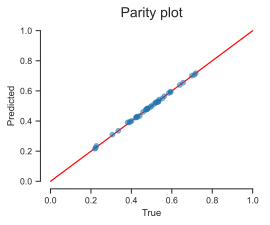

In [368]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title("Parity plot", fontsize=14)
ax.errorbar(u05_test, u05_pred_test_mean, yerr=u05_pred_test_std, fmt='o', label="Predictions", alpha=0.5)
ax.plot([0, 1], [0, 1], 'r-', label="Ideal")
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
sns.despine(trim=True);

The fit looks good.

## Uncertainty propagation

We can now use the surrogate to do uncertainty quantification tasks for very cheap!

For example, let's visualize the distribution of $u_{0.5}$:

In [369]:
xi = jrandom.normal(key, shape=(2000, kle.num_xi,))
u05 = eval_gp(xi, xi_train, u05_train[:, None], posterior)

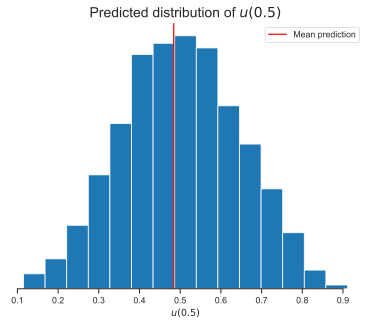

In [370]:
fig, ax = plt.subplots()
ax.hist(u05[0], bins=15, density=True)
ax.axvline(u05_pred_test_mean.mean(), color='r', label="Mean prediction")
ax.set_xlabel(r"$u(0.5)$")
ax.set_title("Predicted distribution of $u(0.5)$", fontsize=14)
ax.legend()
ax.set_yticks([])
sns.despine(trim=True, left=True);